In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 

from scipy.optimize import curve_fit


In [2]:
def piecewise_exponential_cumulative(ages, k1, k2, m=94):
    ### this function calculates a piecewise exponential function, whose integral equals one
    # k1 is the decay rate of first exponential
    # k2 is decay rate of secodn exponetial
    # m is the boundary between k1 and k2
    n_age_bins = len(ages)
    
    # calculate the frequency of youngest age bin
    a = 1./((1./k1)+np.exp(-k1*m)*((-1/k1)+(1/k2)))
    
    # calculate the first piecewise exponential set
    vals = a * np.exp(-k1*ages)
    ##print(len(vals[m:]))
    ##print(len(np.arange(n_age_bins-m)))
    ##print(len(ages.isel(slice(m-n_age_bins, None))))
    
    # calculate the second piecewise exponential set, beginning with the last element ofthe first set
    vals[m:] = vals[m]*np.exp(-k2*np.arange(n_age_bins-m))
    
    # rescale last age bin to account for all of the truncated ages beyond
    #vals[-1] = vals[-1]/k2

    vals_cumulative = vals.cumsum()
    return(vals_cumulative)

In [3]:
fin_luh2 = xr.open_dataset('LUH2_states_transitions_management.timeseries_4x5_hist_simyr1650-2015_c240216.nc')

fin_luh2['time'] = fin_luh2.time+850

In [4]:
nages = 300
ntime_total = len(fin_luh2.time)
IM = len(fin_luh2.lon)
JM = len(fin_luh2.lat)

ages = xr.DataArray(np.arange(nages), dims=['age'], coords=[np.arange(nages)])

age_mature=94

In [5]:
area_prim = fin_luh2.primf + fin_luh2.primn


In [6]:
rate_newsec_creation = fin_luh2.primf_harv + fin_luh2.primn_harv + fin_luh2.primf_to_secdn + fin_luh2.primn_to_secdf  + fin_luh2.urban_to_secdf  + fin_luh2.urban_to_secdn  + fin_luh2.c3ann_to_secdf  + fin_luh2.c3ann_to_secdn  + fin_luh2.c4ann_to_secdf  + fin_luh2.c4ann_to_secdn  + fin_luh2.c3per_to_secdf  + fin_luh2.c3per_to_secdn  + fin_luh2.c4per_to_secdf  + fin_luh2.c4per_to_secdn  + fin_luh2.c3nfx_to_secdf  + fin_luh2.c3nfx_to_secdn  + fin_luh2.pastr_to_secdf  + fin_luh2.pastr_to_secdn  + fin_luh2.range_to_secdf  + fin_luh2.range_to_secdn 

rate_sec_loss_transitions = fin_luh2.secdf_to_urban + fin_luh2.secdf_to_c3ann + fin_luh2.secdf_to_c4ann + fin_luh2.secdf_to_c3per + fin_luh2.secdf_to_c4per + fin_luh2.secdf_to_c3nfx + fin_luh2.secdf_to_pastr + fin_luh2.secdf_to_range + fin_luh2.secdn_to_urban + fin_luh2.secdn_to_c3ann + fin_luh2.secdn_to_c4ann + fin_luh2.secdn_to_c3per + fin_luh2.secdn_to_c4per + fin_luh2.secdn_to_c3nfx + fin_luh2.secdn_to_pastr + fin_luh2.secdn_to_range

secmf_harv = fin_luh2.secmf_harv
secyf_harv = fin_luh2.secyf_harv
secnf_harv = fin_luh2.secnf_harv


In [7]:
age_dist = xr.DataArray(np.zeros((ntime_total,nages,JM,IM)), dims=['time','age','lsmlat','lsmlon'], coords=[fin_luh2.time, ages, fin_luh2.lsmlat, fin_luh2.lsmlon])

secy_dist = xr.DataArray(np.zeros((ntime_total,JM,IM)), dims=['time','lsmlat','lsmlon'], coords=[fin_luh2.time, fin_luh2.lsmlat, fin_luh2.lsmlon])
secm_dist = xr.DataArray(np.zeros((ntime_total,JM,IM)), dims=['time','lsmlat','lsmlon'], coords=[fin_luh2.time, fin_luh2.lsmlat, fin_luh2.lsmlon])

k_secloss_dist = xr.DataArray(np.zeros((ntime_total,JM,IM)), dims=['time','lsmlat','lsmlon'], coords=[fin_luh2.time, fin_luh2.lsmlat, fin_luh2.lsmlon])
k_secyhar_dist = xr.DataArray(np.zeros((ntime_total,JM,IM)), dims=['time','lsmlat','lsmlon'], coords=[fin_luh2.time, fin_luh2.lsmlat, fin_luh2.lsmlon])
k_secthar_dist = xr.DataArray(np.zeros((ntime_total,JM,IM)), dims=['time','lsmlat','lsmlon'], coords=[fin_luh2.time, fin_luh2.lsmlat, fin_luh2.lsmlon])
k_secmhar_dist = xr.DataArray(np.zeros((ntime_total,JM,IM)), dims=['time','lsmlat','lsmlon'], coords=[fin_luh2.time, fin_luh2.lsmlat, fin_luh2.lsmlon])


In [8]:
### initialize the secondary forest age as having all zero age at start of dataset

sectot = fin_luh2.secdf + fin_luh2.secdn
age_dist[0,0,:,:] = sectot.isel(time=0)

In [9]:
for t in range(ntime_total-1):
    if t%50 == 0:
        print('starting year ',t)
    secy = age_dist.isel(time=t).isel(age=slice(0,age_mature)).sum(dim='age')
    secm = age_dist.isel(time=t).isel(age=slice(age_mature,None)).sum(dim='age')
    
    age_dist[t+1,0,:,:] = rate_newsec_creation.isel(time=t)
    k_secloss = np.minimum(1.,np.nan_to_num(rate_sec_loss_transitions.isel(time=t)/sectot.isel(time=t)))
    k_secyhar = np.minimum(1.,np.nan_to_num(secyf_harv.isel(time=t)/secy))
    k_secthar = np.minimum(1.,np.nan_to_num(secnf_harv.isel(time=t)/sectot.isel(time=t)))
    k_secmhar = np.minimum(1.,np.nan_to_num(secmf_harv.isel(time=t)/secm))

    for age in range(age_mature):
        age_dist[t+1,age+1] = age_dist[t,age] * (1. - np.minimum(1.,(k_secloss + k_secyhar + k_secthar)))
        age_dist[t+1,0] = age_dist[t+1,0] + age_dist[t,age] * np.minimum(1.,(k_secyhar + k_secthar))
    for age in range(age_mature,nages-2):
        age_dist[t+1,age+1] = age_dist[t,age] * (1.- np.minimum(1.,(k_secloss + k_secmhar + k_secthar)))
        age_dist[t+1,0] = age_dist[t+1,0] + age_dist[t,age] * np.minimum(1.,(k_secmhar + k_secthar))
    age_dist[t+1,nages-1] = (age_dist[t,nages-1] + age_dist[t,nages-2]) * (1.- np.minimum(1.,(k_secloss + k_secmhar + k_secthar)))
    age_dist[t+1,0] = age_dist[t+1,0] + (age_dist[t,nages-1] + age_dist[t,nages-2]) * np.minimum(1.,(k_secmhar + k_secthar))

    secy_dist[t,:,:] = secy
    secm_dist[t,:,:] = secm
    k_secloss_dist[t,:,:] = k_secloss
    k_secyhar_dist[t,:,:] = k_secyhar
    k_secthar_dist[t,:,:] = k_secthar
    k_secmhar_dist[t,:,:] = k_secmhar

starting year  0
starting year  50
starting year  100
starting year  150
starting year  200
starting year  250
starting year  300
starting year  350
starting year  400
starting year  450
starting year  500
starting year  550
starting year  600
starting year  650
starting year  700
starting year  750
starting year  800
starting year  850
starting year  900
starting year  950
starting year  1000
starting year  1050
starting year  1100
starting year  1150


In [10]:
age_dist_cum = age_dist.cumsum(dim='age')

In [11]:
mean_age = (age_dist * ages).sum(dim='age') / age_dist.sum(dim='age')

In [12]:
age_dist_cum_norm = age_dist_cum / sectot

In [13]:
median_secondary_age = np.abs(age_dist_cum_norm.fillna(0.) - 0.5).argmin(dim='age', skipna=True)
median_secondary_age = (median_secondary_age * sectot / sectot)

In [44]:
sec_young_harvestrate_rel = xr.DataArray(np.nan * np.ones([JM,IM]), dims=['lsmlat','lsmlon'], coords=[fin_luh2.lat, fin_luh2.lon])
sec_mature_harvestrate_rel = xr.DataArray(np.nan * np.ones([JM,IM]), dims=['lsmlat','lsmlon'], coords=[fin_luh2.lat, fin_luh2.lon])


time = 1164
n_age_max = 150

x = ages.isel(age=slice(0,n_age_max)).data
fails = xr.DataArray(np.nan * np.ones([JM,IM]), dims=['lsmlat','lsmlon'], coords=[fin_luh2.lat, fin_luh2.lon])
for i in range(IM):
    for j in range(JM):
        if sectot.sel(lsmlat=j,lsmlon=i,time=time) > 0.:
            y = age_dist_cum_norm.isel(lsmlat=j,lsmlon=i,time=time,age=slice(0,n_age_max)).data
            try:
                params = curve_fit(piecewise_exponential_cumulative, x, y, p0=[0.01,0.01], bounds=[0,1])
                #print(params)
                sec_young_harvestrate_rel[j,i] = params[0][0]
                sec_mature_harvestrate_rel[j,i] = params[0][1]
            except:
                fails[j,i] = 1.
                sec_young_harvestrate_rel[j,i] = 0.05  ### set to some nominal value
                sec_mature_harvestrate_rel[j,i] = 0.05  ### set to some nominal value
        

/var/folders/6g/x_x6jm6s1jq6fz2gmv70hhdh0000gp/T/ipykernel_41547/3908733213.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  a = 1./((1./k1)+np.exp(-k1*m)*((-1/k1)+(1/k2)))


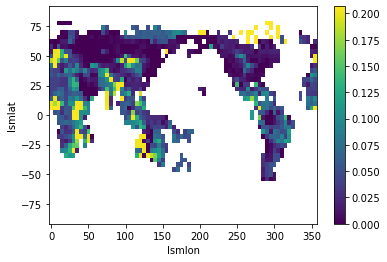

In [45]:
sec_young_harvestrate_rel.plot()

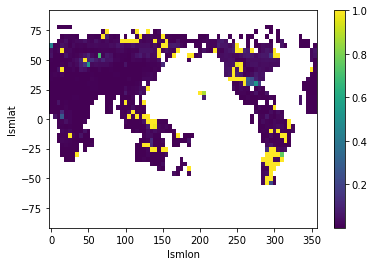

In [46]:
sec_mature_harvestrate_rel.plot()

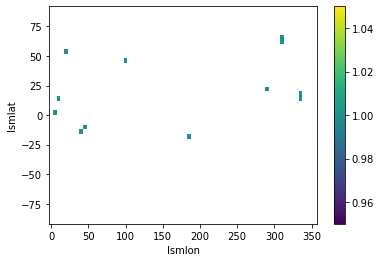

In [47]:
fails.plot()

In [48]:
# replace nans with zeros in harvest rates
sec_young_harvestrate_rel = sec_young_harvestrate_rel.fillna(0.)
sec_mature_harvestrate_rel = sec_mature_harvestrate_rel.fillna(0.)

In [49]:
n_ts_out = 500
fout = fin_luh2.sel(time=[time]*n_ts_out)

In [50]:
# first zero all transitions
varlist =  list(fout.variables)
matchers = ['_to_','_harv','_bioh']
matching_vars = [s for s in varlist if any(xs in s for xs in matchers)]
#matching_vars

# Loop over variables governing transition rates and zero them
for var in matching_vars:
    # Access the variable data
    fout[var] = fout[var] * 0.


In [51]:
# now rewrite the secondary harvest rates based on the fits above

for i_ts in range(n_ts_out):
    fout.secyf_harv[i_ts,:,:] = sec_young_harvestrate_rel * (fout.secdf.isel(time=0) + fout.secdn.isel(time=0)).data
    fout.secmf_harv[i_ts,:,:] = sec_mature_harvestrate_rel * (fout.secdf.isel(time=0) + fout.secdn.isel(time=0)).data



In [53]:
fout['time'] = np.arange(n_ts_out)
fout['YEAR'][:] = np.arange(n_ts_out)


In [54]:
fout.to_netcdf('LUH2_states_transitions_management.timeseries_4x5_hist_steadystate_2014_29oct2024.nc')